Text(0.5, 1, 'Correlation Matrix')

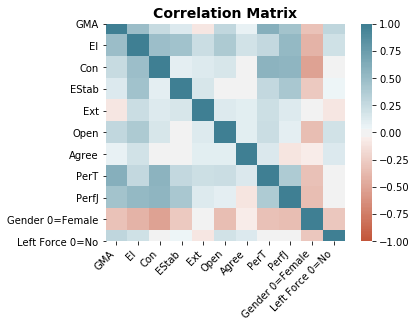

In [1]:
#Reference/Code: https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as stats
from collections import defaultdict

%matplotlib inline

data = pd.read_csv('./PoliceDataFull2021.csv')
#print ("data:", data)
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.title("Correlation Matrix", fontsize="14", fontweight="bold")

#plt.show()


In [2]:
# Reference: Copied and modified from-
# https://stackoverflow.com/questions/27164114/show-confidence-limits-and-prediction-limits-in-scatter-plot


In [3]:
def setupformat(x, ax, plt, title, xlabel, ylabel):
    # Figure Modifications --------------------------------------------------------
    # Borders
    ax.spines["top"].set_color("0.5")
    ax.spines["bottom"].set_color("0.5")
    ax.spines["left"].set_color("0.5")
    ax.spines["right"].set_color("0.5")
    ax.get_xaxis().set_tick_params(direction="out")
    ax.get_yaxis().set_tick_params(direction="out")
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left() 

    # Labels
    plt.title(title, fontsize="14", fontweight="bold")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(np.min(x) - 1, np.max(x) + 1)

    # Custom legend
    handles, labels = ax.get_legend_handles_labels()
    display = (0, 1)
    anyArtist = plt.Line2D((0, 1), (0, 0), color="#b9cfe7")    # create custom artists
    legend = plt.legend(
        [handle for i, handle in enumerate(handles) if i in display] + [anyArtist],
        [label for i, label in enumerate(labels) if i in display] + ["95% Confidence Limits"],
        loc=9, bbox_to_anchor=(0, -0.21, 1., 0.102), ncol=3, mode="expand"
    )  
    frame = legend.get_frame().set_edgecolor("0.5")

    # Save Figure
    plt.tight_layout()
    #plt.savefig("filename.png", bbox_extra_artists=(legend,), bbox_inches="tight")
    #plt.show()

In [4]:
def poststats(x, y, ax, plt):

    #print ("DEBUG x.shape:", x.shape, "y.shape:", y.shape)
    slope, intercept = np.polyfit(np.array(x), np.array(y), 1)  # linear model adjustment

    y_model = np.polyval([slope, intercept], x)   # modeling...

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    n = x.size                        # number of samples
    m = 2                             # number of parameters
    dof = n - m                       # degrees of freedom
    t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence

    residual = y - y_model

    std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

    # calculating the r2
    # https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
    # Pearson's correlation coefficient
    numerator = np.sum((x - x_mean)*(y - y_mean))
    denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
    correlation_coef = numerator / denominator
    r2 = correlation_coef**2

    # mean squared error
    MSE = 1/n * np.sum( (y - y_model)**2 )

    # to plot the adjusted model
    x_line = np.linspace(np.min(x), np.max(x), 100)
    y_line = np.polyval([slope, intercept], x_line)

    # confidence interval
    ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
    # predicting interval
    pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  

    # rounding and position must be changed for each case and preference
    a = str(np.round(intercept))
    b = str(np.round(slope,2))
    r2s = str(np.round(r2,2))
    MSEs = str(np.round(MSE))

    ax.text(ax.get_xlim()[0]*1.1, ax.get_ylim()[1]*0.9, 'y = ' + a + ' + ' + b + ' x' + '\n' + '$r^2$ = ' + r2s + '     MSE = ' + MSEs)
    #plt.legend(loc='upper right', bbox_to_anchor=(1, .25), fontsize=12)
    return r2


In [5]:
def plot_ci_manual(t, s_err, n, x, x2, y, y2, title, xlabel, ylabel, ax=None):
    """Return an axes of confidence bands using a simple approach.
    
    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}
    
    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    
    """
    
    if ax is None:
        ax = plt.gca()
    
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7", edgecolor="")
    setupformat(x, ax, plt, title, xlabel, ylabel)
    r2 = poststats(x, y,ax,plt)
    #return ax
    return r2

In [6]:
# Computations ----------------------------------------------------------------    
# Plot scatter plot with CI and PI using linear regression
# Returns r**2 for the plot
def plot(x, y, title, xlabel, ylabel):
    # Modeling with Numpy
    def equation(a, b):
        """Return a 1D polynomial."""
        return np.polyval(a, b) 

    p, cov = np.polyfit(np.array(x), np.array(y), 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
    y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

    # Statistics
    n = x.size                                                 # number of observations
    m = p.size                                                 # number of parameters
    dof = n - m                                                # degrees of freedom
    t = stats.t.ppf(0.975, n - m)                              # used for CI and PI bands

    # Estimates of Error in Data/Model
    resid = y - y_model                           
    chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

    # Plotting --------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8, 6))

    # Data
    ax.plot(
        x, y, "o", color="#b9cfe7", markersize=8, 
        markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
    )

    # Fit
    ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

    x2 = np.linspace(np.min(x), np.max(x), 100)
    y2 = equation(p, x2)

    # Prediction Interval
    pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
    ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
    ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
    ax.plot(x2, y2 + pi, "--", color="0.5")

    # Confidence Interval (select one)
    r2 = plot_ci_manual(t, s_err, n, x, x2, y, y2, title, xlabel, ylabel, ax=ax)
    #plot_ci_bootstrap(x, y, resid, ax=ax)

    plt.show()
    return r2

In [7]:
# Actually plotting real police data!!

Graph 1 : Plotting EI vs GMA


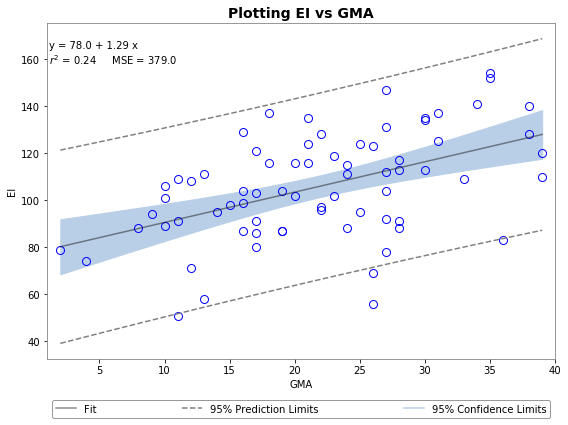

Graph 2 : Plotting Con vs GMA


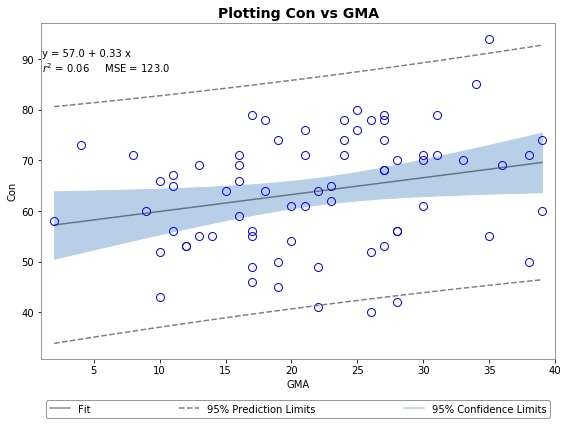

Graph 3 : Plotting EStab vs GMA


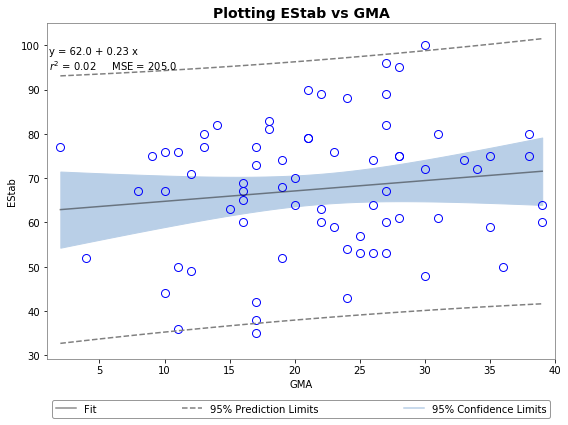

Graph 4 : Plotting Ext vs GMA


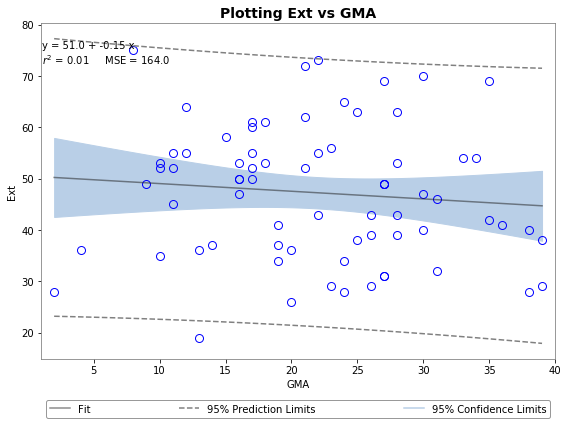

Graph 5 : Plotting Open vs GMA


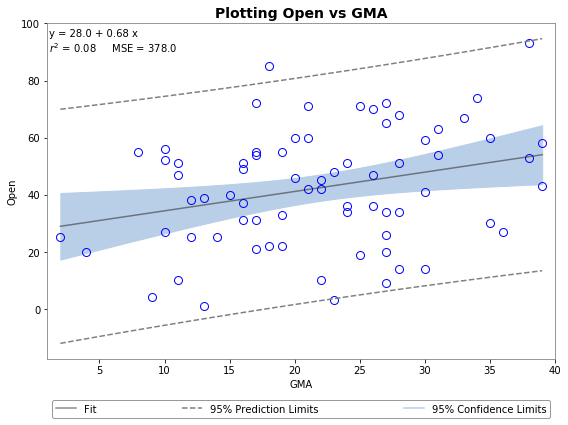

Graph 6 : Plotting Agree vs GMA


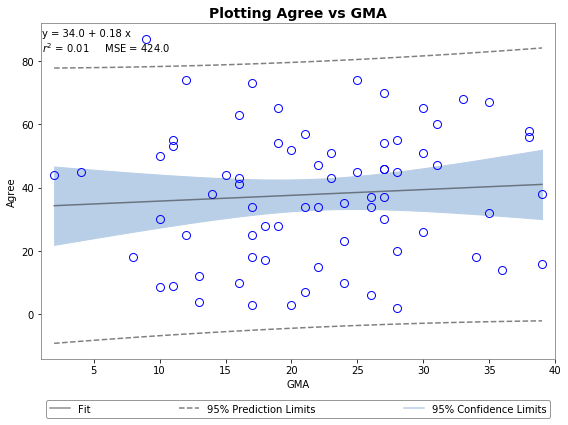

Graph 7 : Plotting PerT vs GMA


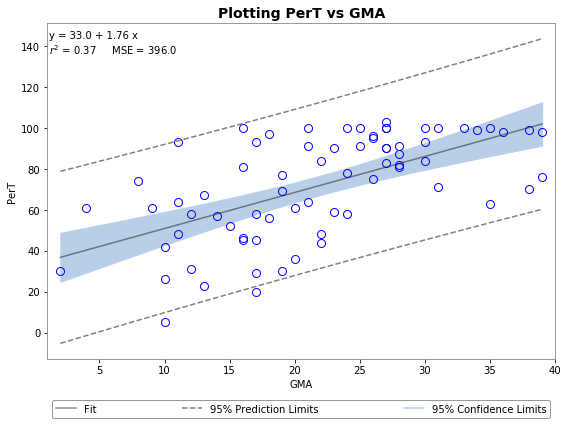

Graph 8 : Plotting PerfJ vs GMA


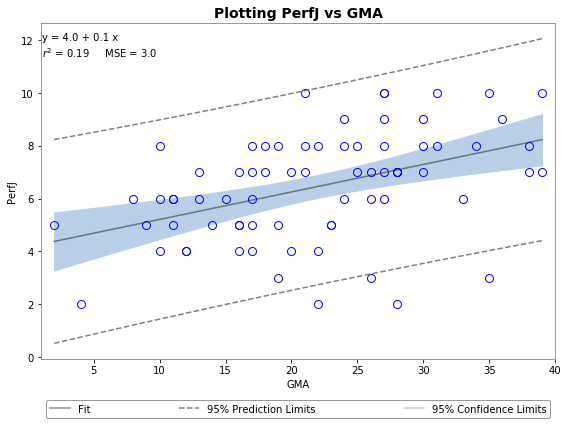

Graph 9 : Plotting Gender 0=Female vs GMA


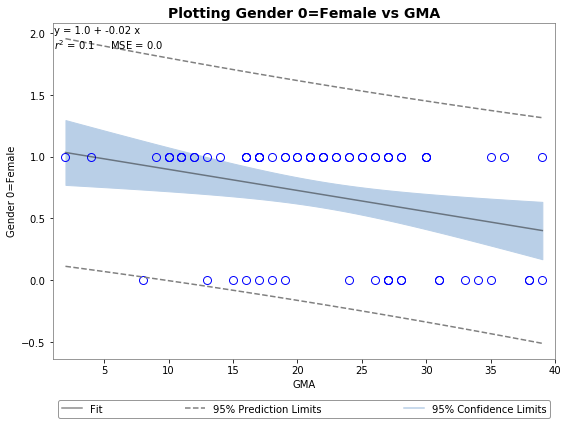

Graph 10 : Plotting Left Force 0=No vs GMA


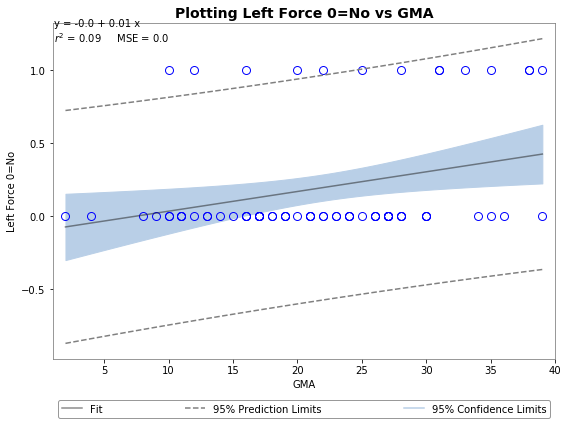

Graph 11 : Plotting GMA vs EI


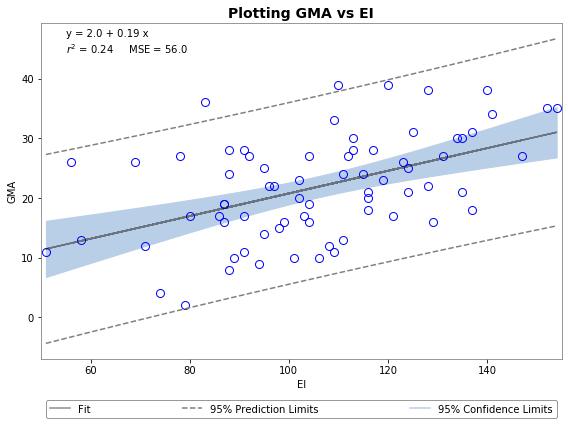

Graph 12 : Plotting Con vs EI


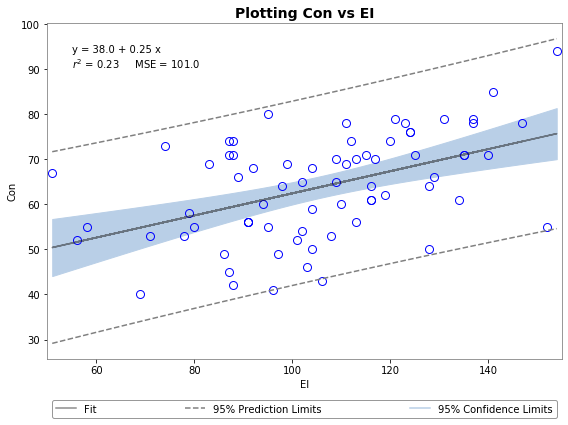

Graph 13 : Plotting EStab vs EI


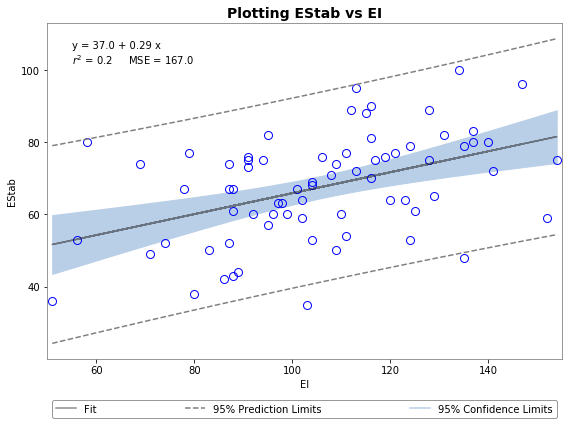

Graph 14 : Plotting Ext vs EI


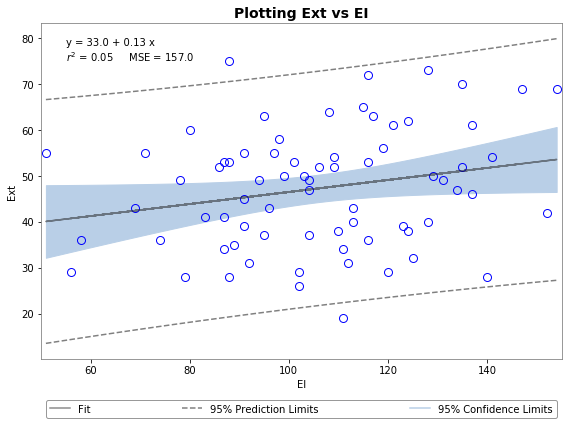

Graph 15 : Plotting Open vs EI


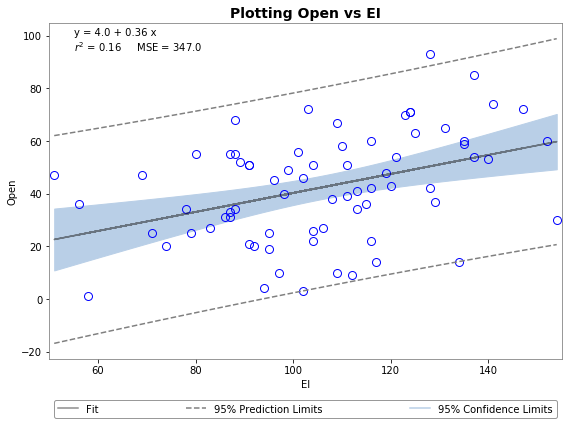

Graph 16 : Plotting Agree vs EI


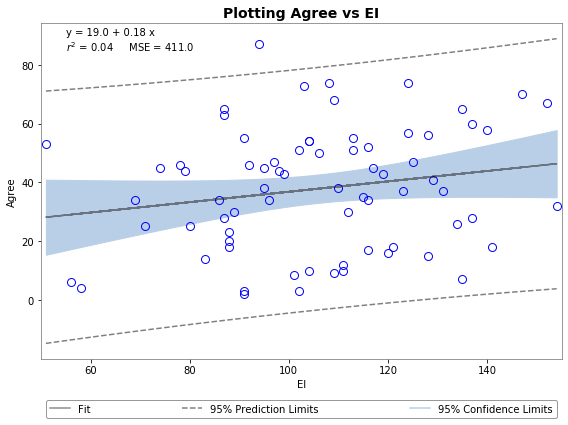

Graph 17 : Plotting PerT vs EI


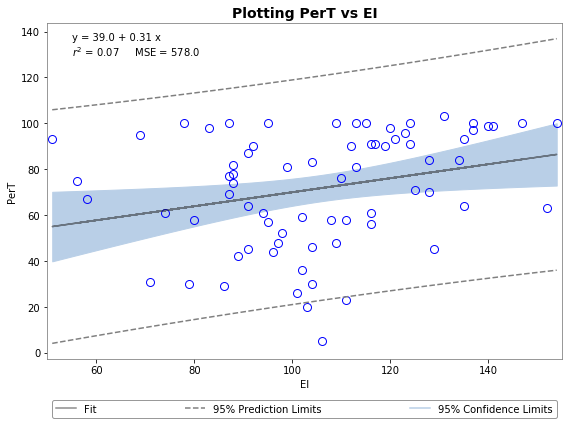

Graph 18 : Plotting PerfJ vs EI


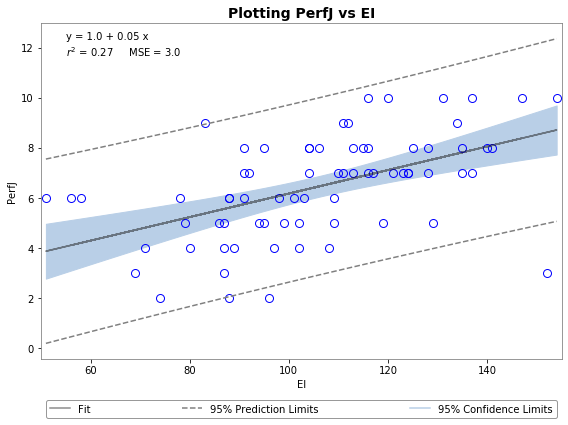

Graph 19 : Plotting Gender 0=Female vs EI


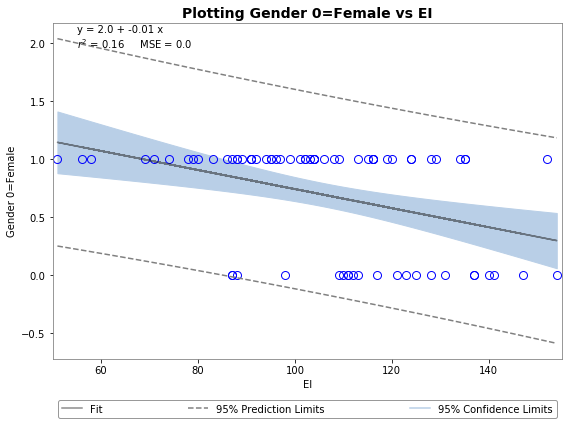

Graph 20 : Plotting Left Force 0=No vs EI


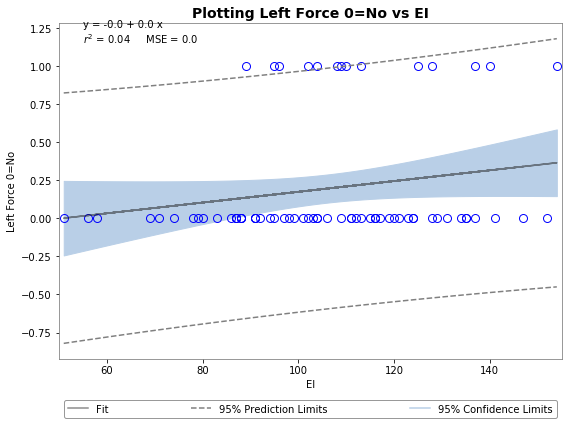

Graph 21 : Plotting GMA vs Con


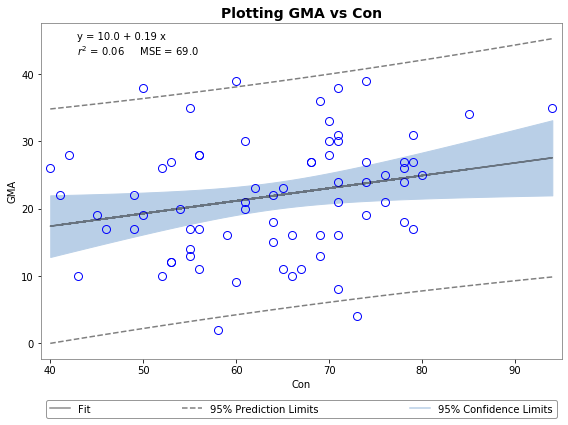

Graph 22 : Plotting EI vs Con


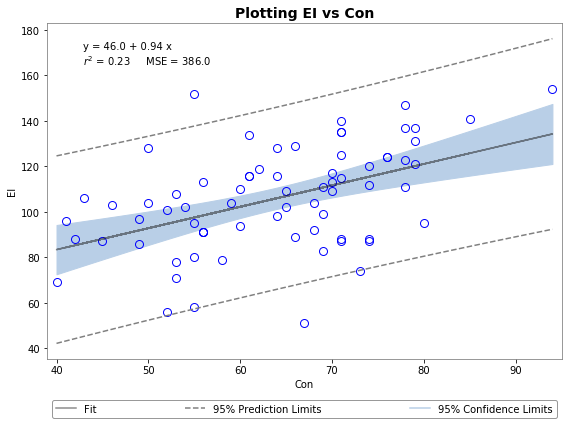

Graph 23 : Plotting EStab vs Con


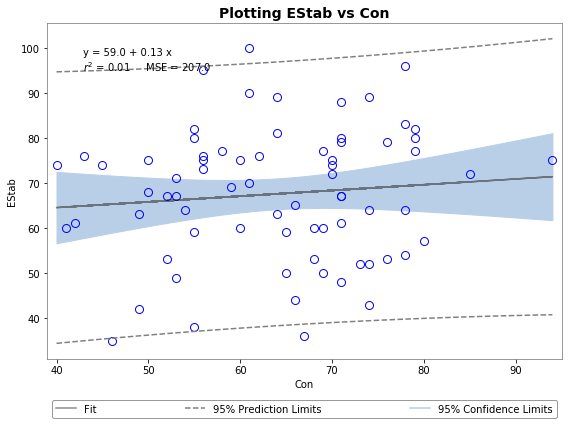

Graph 24 : Plotting Ext vs Con


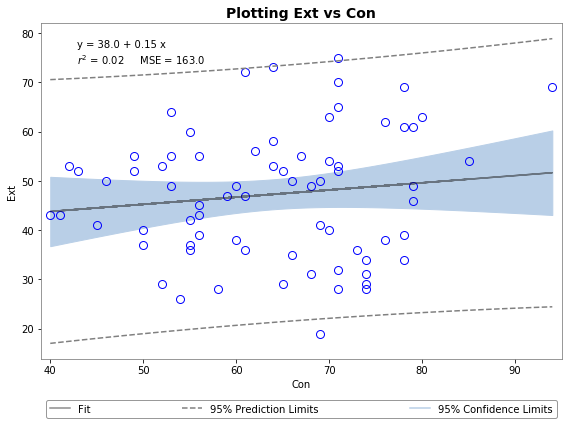

Graph 25 : Plotting Open vs Con


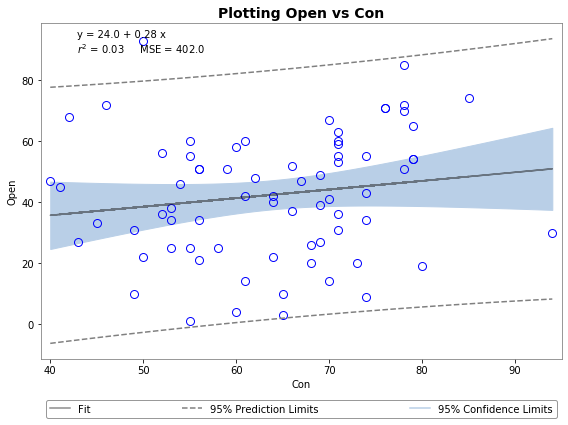

Graph 26 : Plotting Agree vs Con


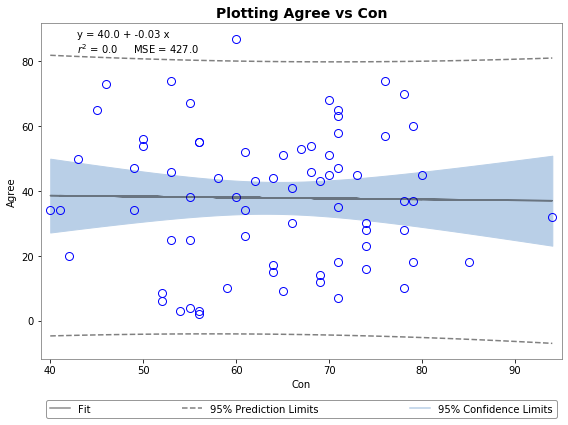

Graph 27 : Plotting PerT vs Con


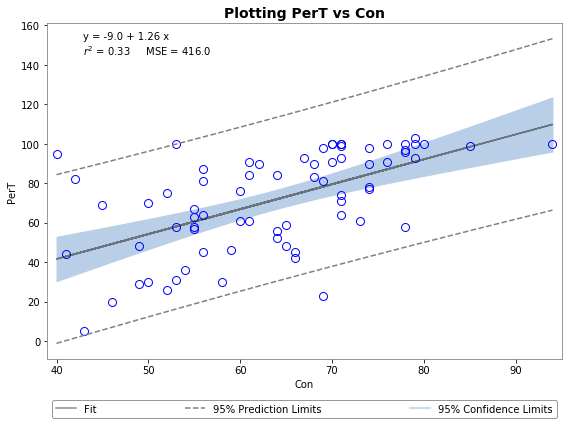

Graph 28 : Plotting PerfJ vs Con


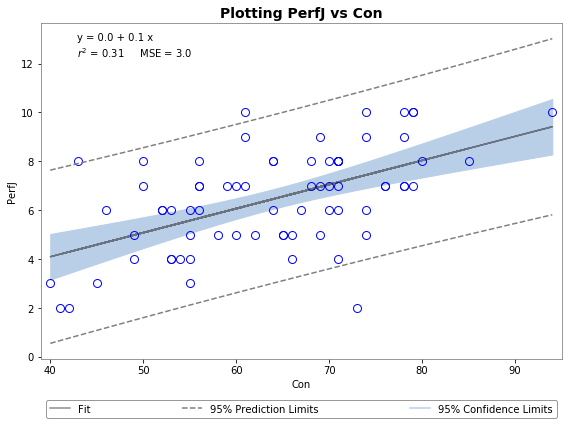

Graph 29 : Plotting Gender 0=Female vs Con


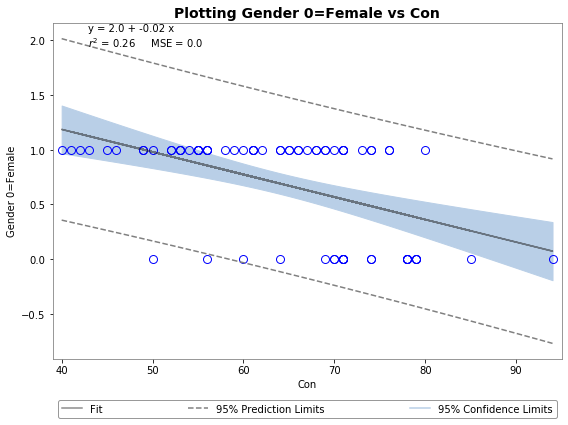

Graph 30 : Plotting Left Force 0=No vs Con


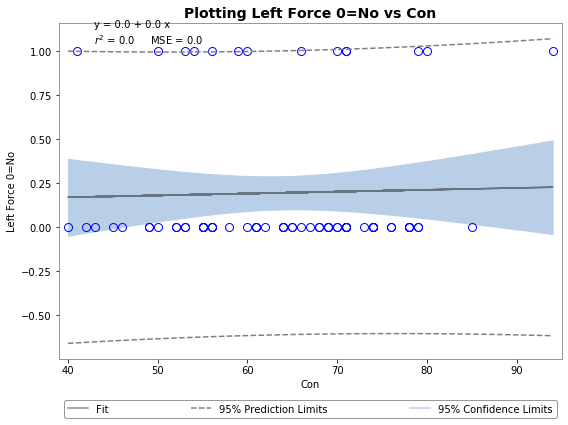

Graph 31 : Plotting GMA vs EStab


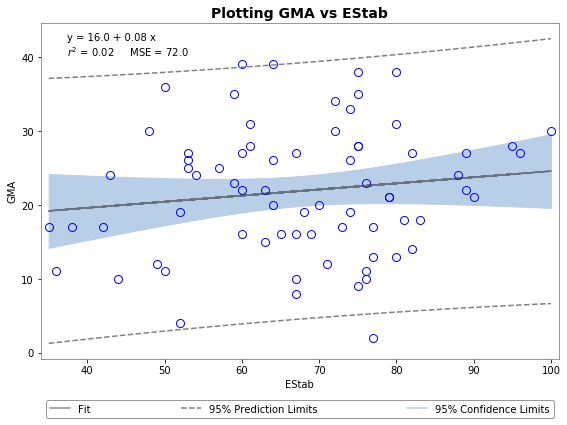

Graph 32 : Plotting EI vs EStab


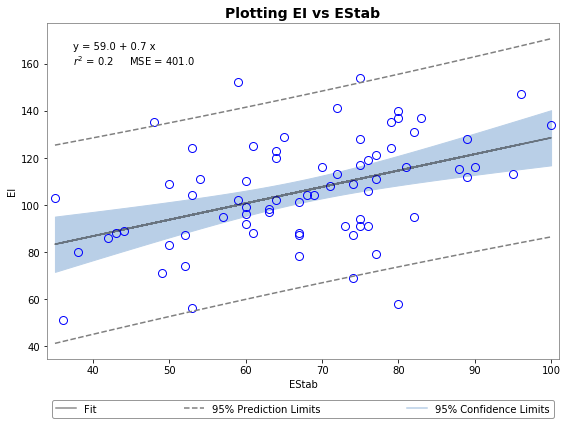

Graph 33 : Plotting Con vs EStab


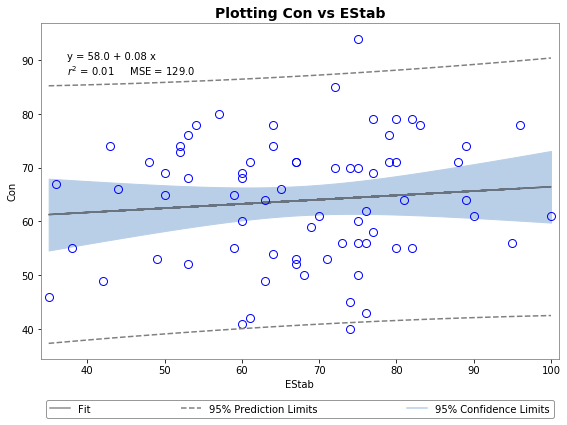

Graph 34 : Plotting Ext vs EStab


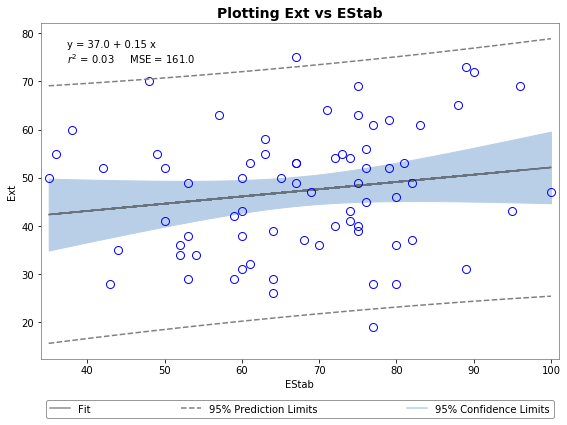

Graph 35 : Plotting Open vs EStab


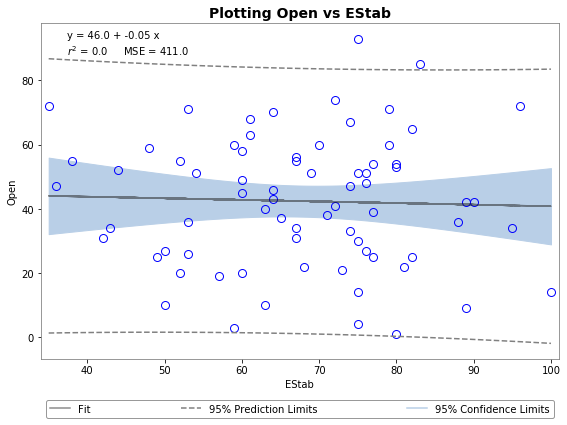

Graph 36 : Plotting Agree vs EStab


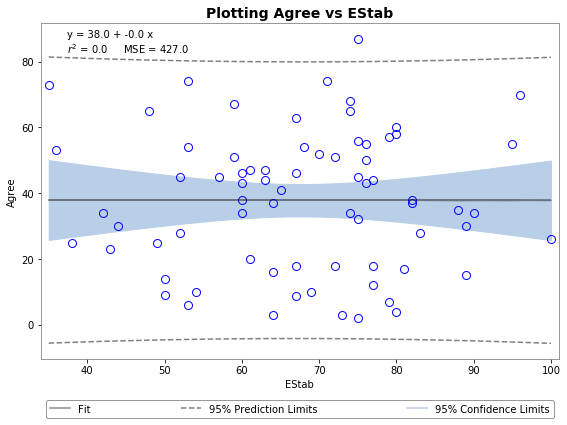

Graph 37 : Plotting PerT vs EStab


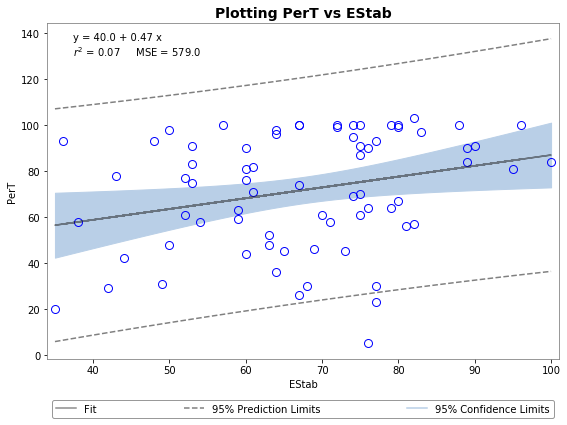

Graph 38 : Plotting PerfJ vs EStab


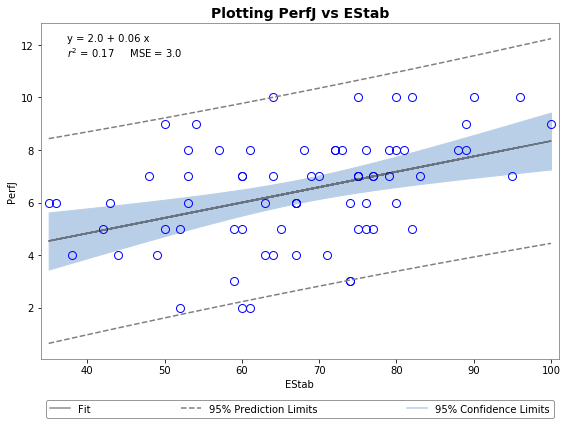

Graph 39 : Plotting Gender 0=Female vs EStab


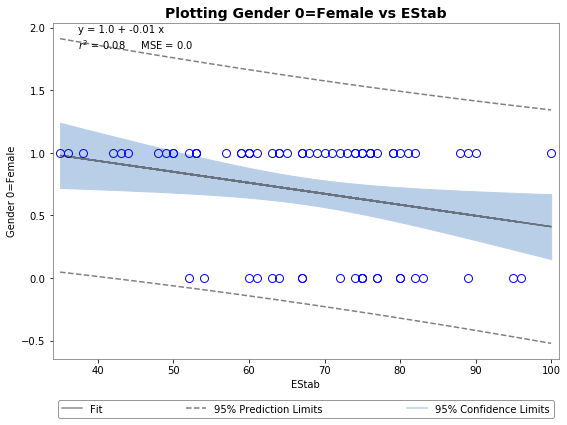

Graph 40 : Plotting Left Force 0=No vs EStab


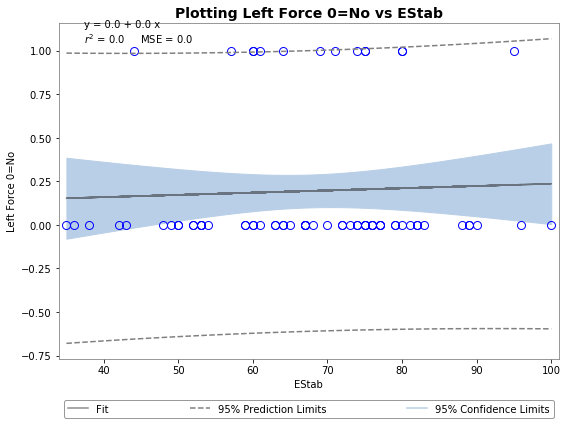

Graph 41 : Plotting GMA vs Ext


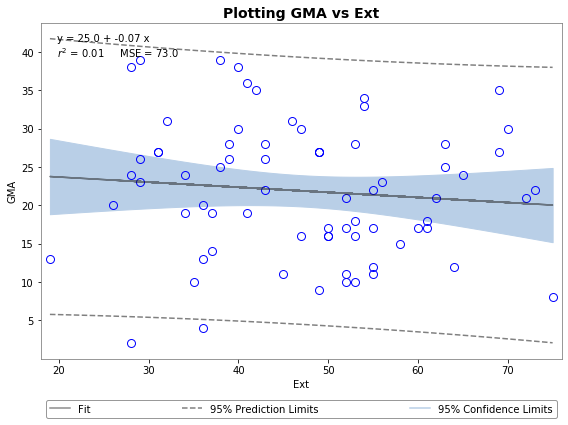

Graph 42 : Plotting EI vs Ext


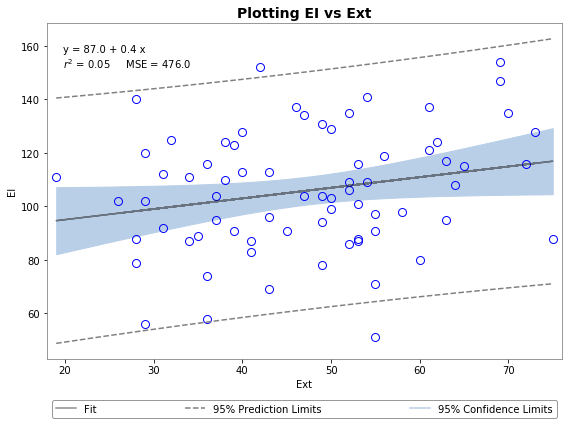

Graph 43 : Plotting Con vs Ext


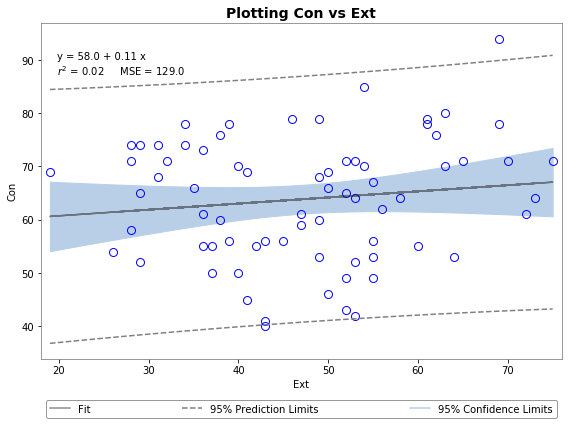

Graph 44 : Plotting EStab vs Ext


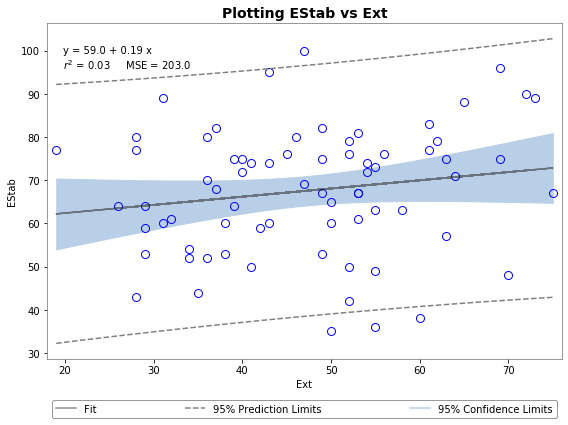

Graph 45 : Plotting Open vs Ext


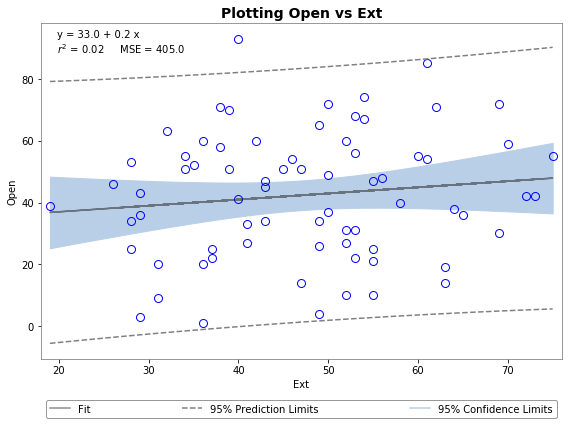

Graph 46 : Plotting Agree vs Ext


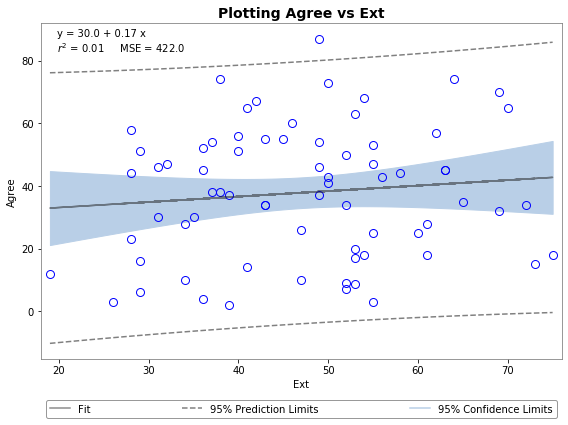

Graph 47 : Plotting PerT vs Ext


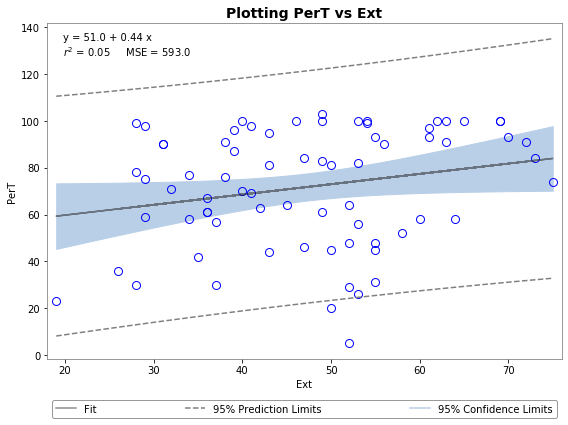

Graph 48 : Plotting PerfJ vs Ext


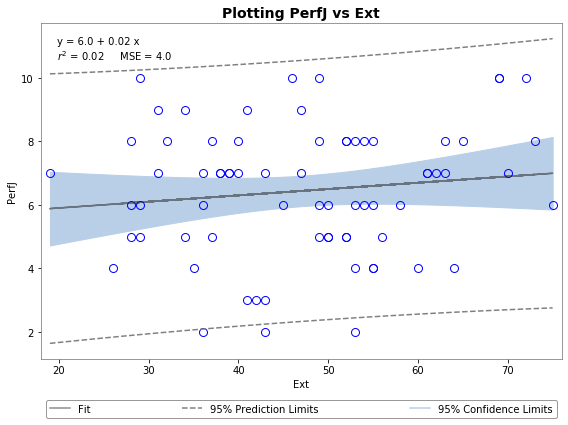

Graph 49 : Plotting Gender 0=Female vs Ext


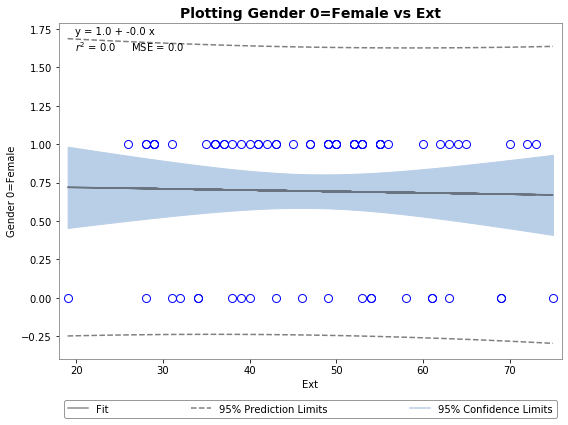

Graph 50 : Plotting Left Force 0=No vs Ext


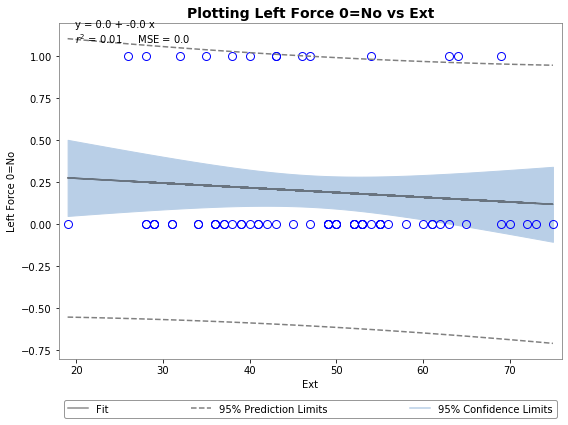

Graph 51 : Plotting GMA vs Open


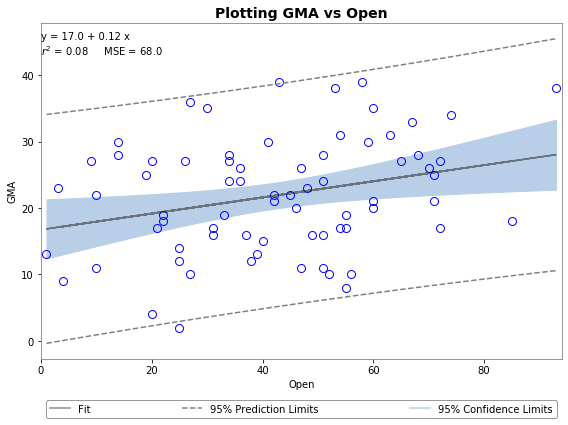

Graph 52 : Plotting EI vs Open


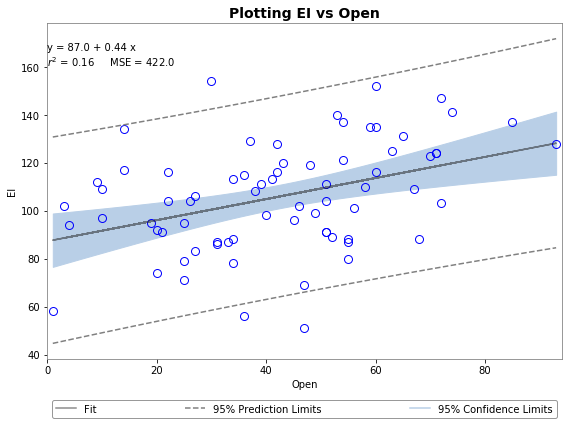

Graph 53 : Plotting Con vs Open


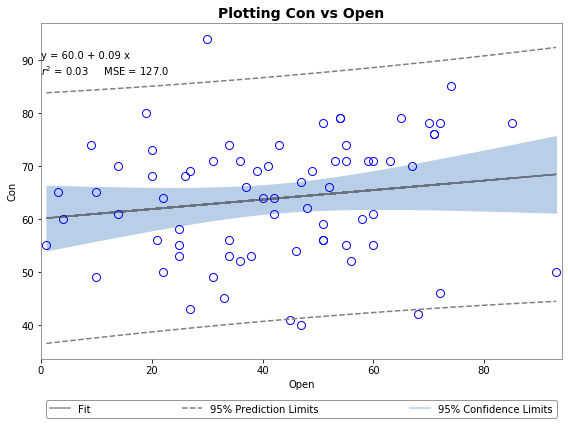

Graph 54 : Plotting EStab vs Open


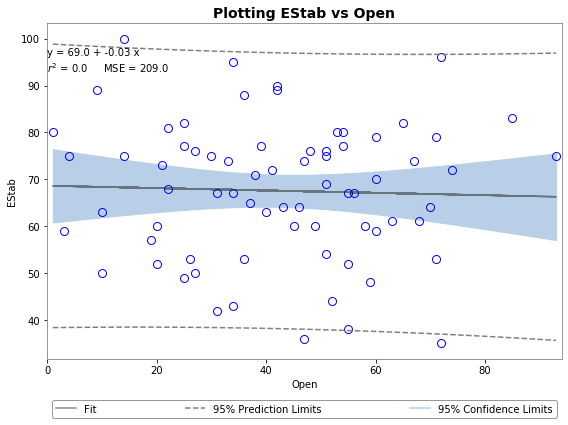

Graph 55 : Plotting Ext vs Open


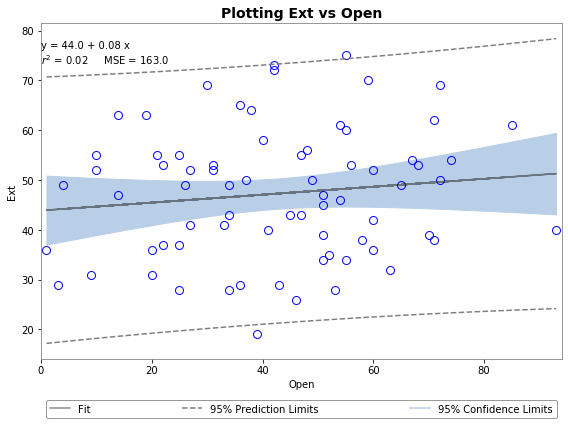

Graph 56 : Plotting Agree vs Open


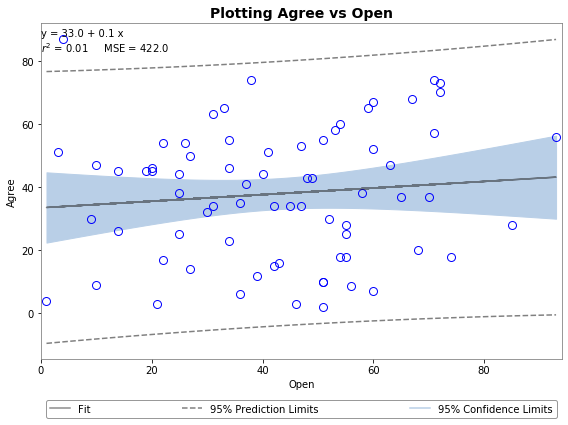

Graph 57 : Plotting PerT vs Open


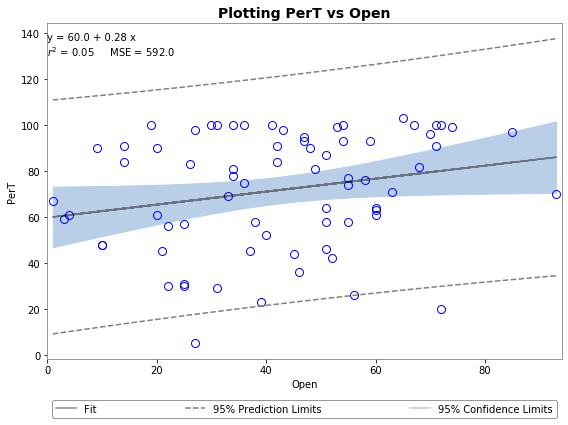

Graph 58 : Plotting PerfJ vs Open


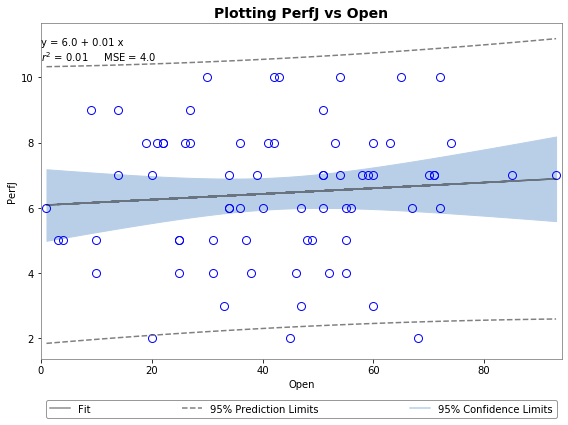

Graph 59 : Plotting Gender 0=Female vs Open


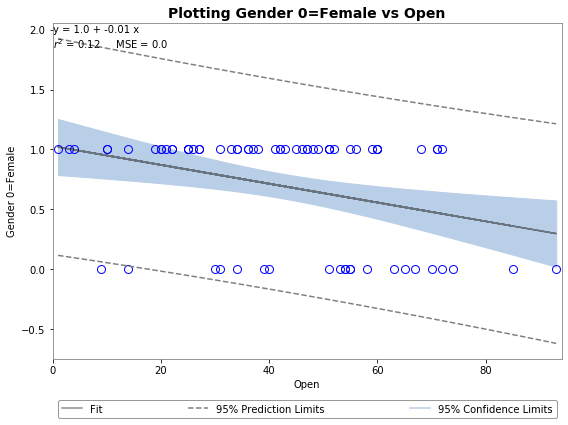

Graph 60 : Plotting Left Force 0=No vs Open


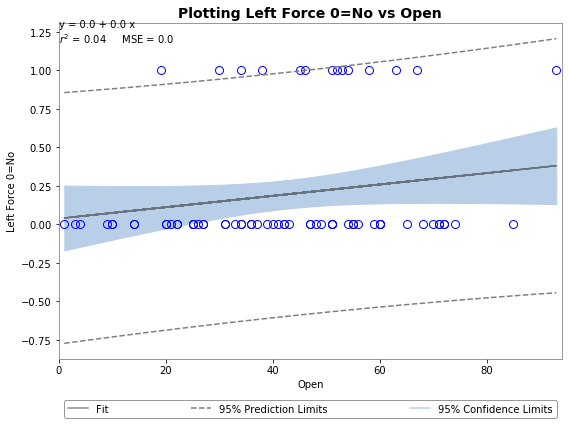

Graph 61 : Plotting GMA vs Agree


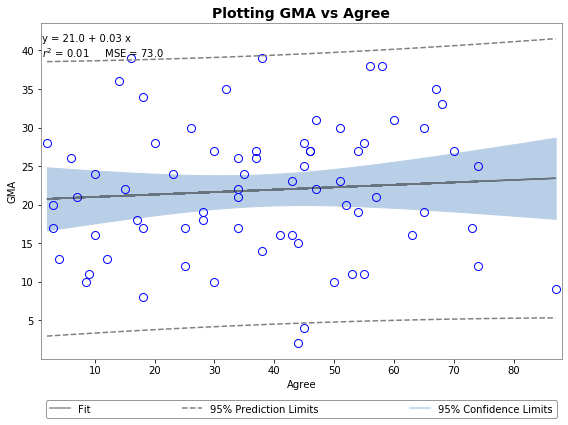

Graph 62 : Plotting EI vs Agree


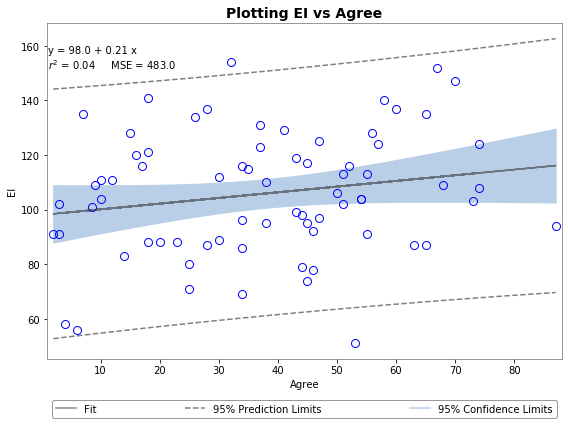

Graph 63 : Plotting Con vs Agree


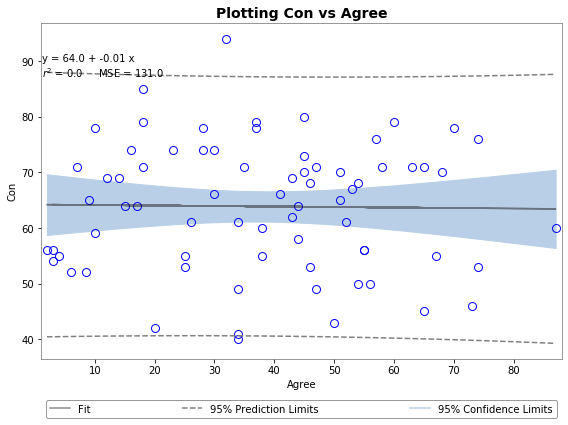

Graph 64 : Plotting EStab vs Agree


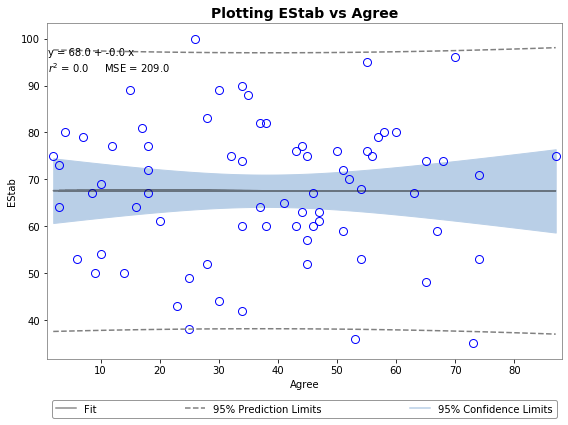

Graph 65 : Plotting Ext vs Agree


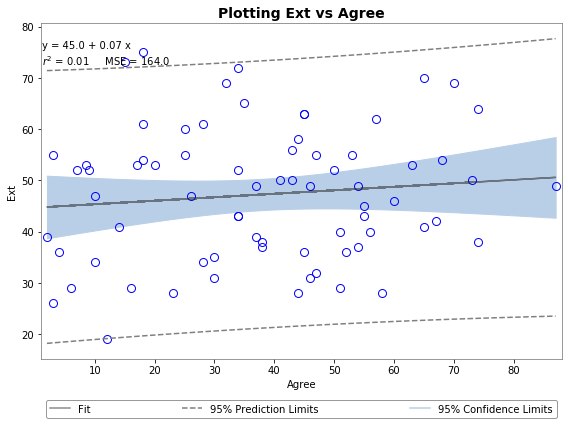

Graph 66 : Plotting Open vs Agree


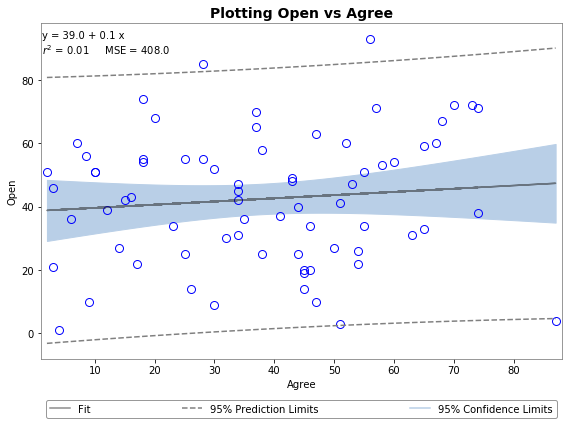

Graph 67 : Plotting PerT vs Agree


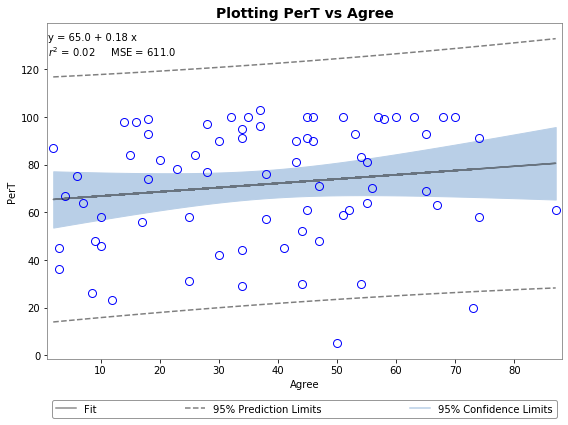

Graph 68 : Plotting PerfJ vs Agree


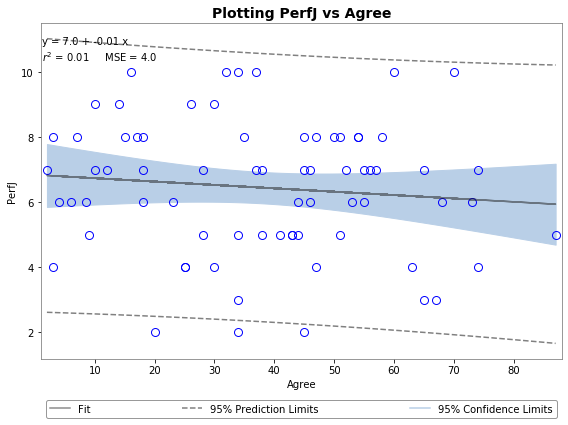

Graph 69 : Plotting Gender 0=Female vs Agree


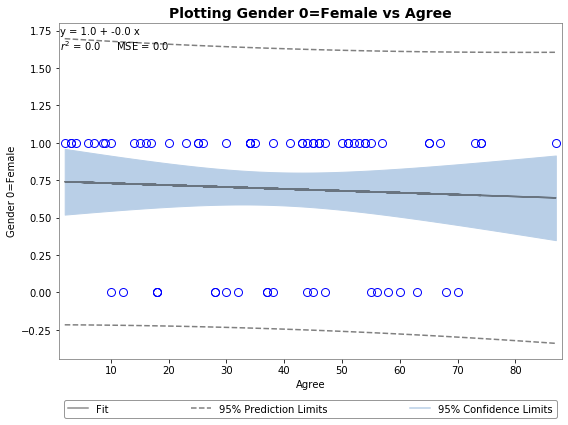

Graph 70 : Plotting Left Force 0=No vs Agree


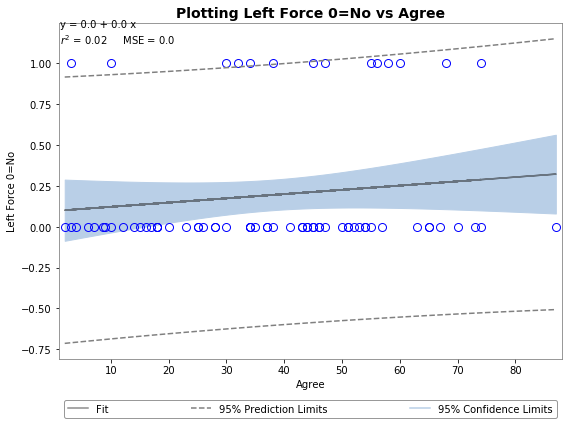

Graph 71 : Plotting GMA vs PerT


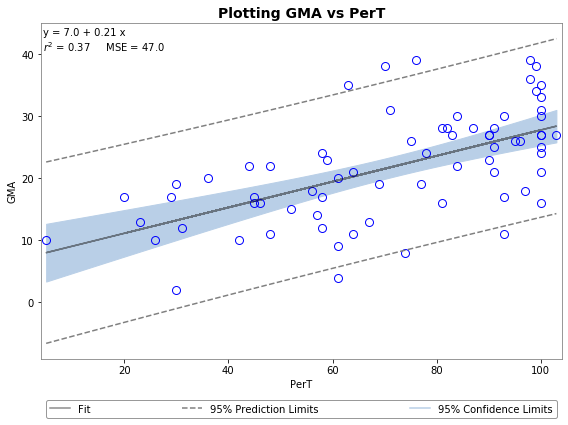

Graph 72 : Plotting EI vs PerT


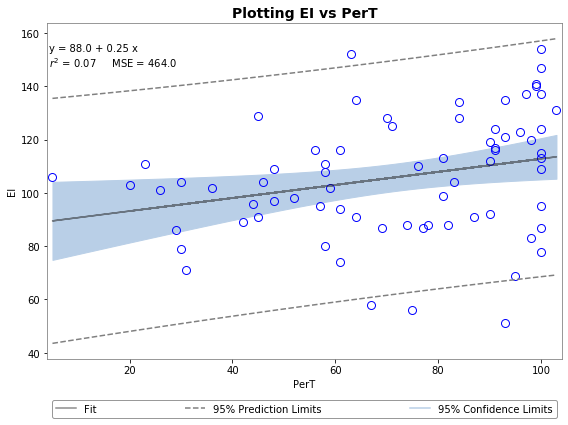

Graph 73 : Plotting Con vs PerT


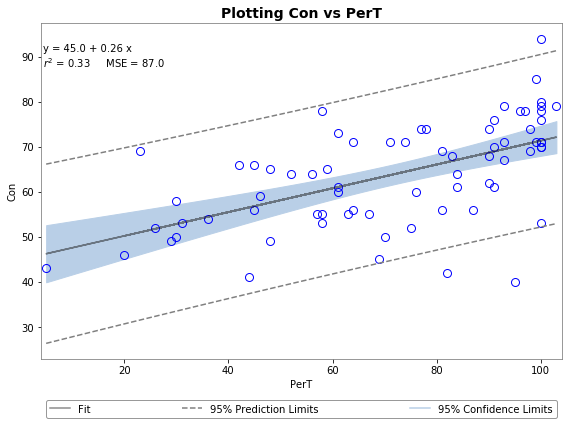

Graph 74 : Plotting EStab vs PerT


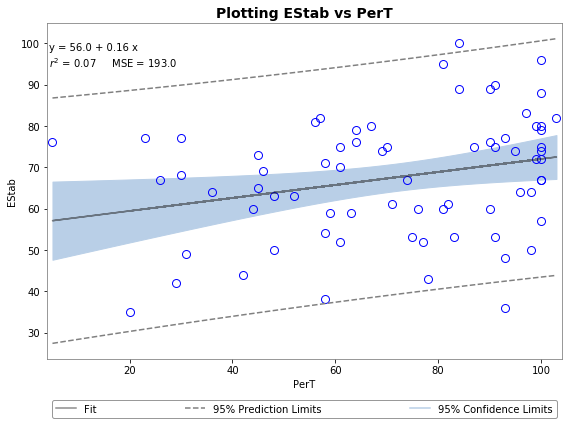

Graph 75 : Plotting Ext vs PerT


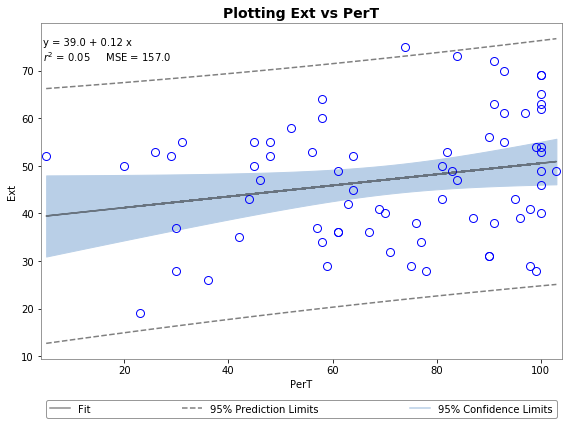

Graph 76 : Plotting Open vs PerT


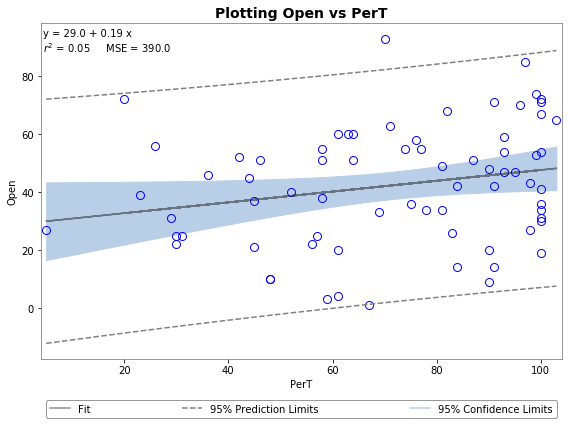

Graph 77 : Plotting Agree vs PerT


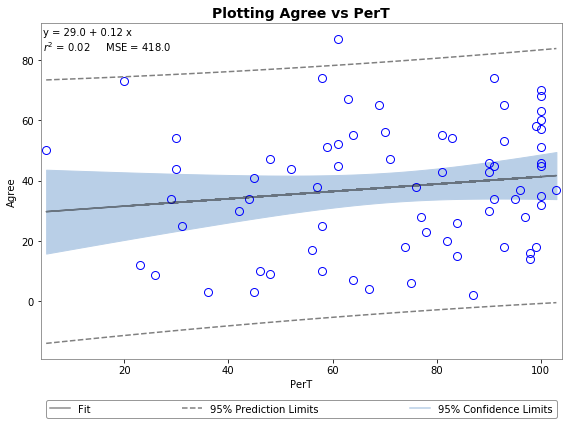

Graph 78 : Plotting PerfJ vs PerT


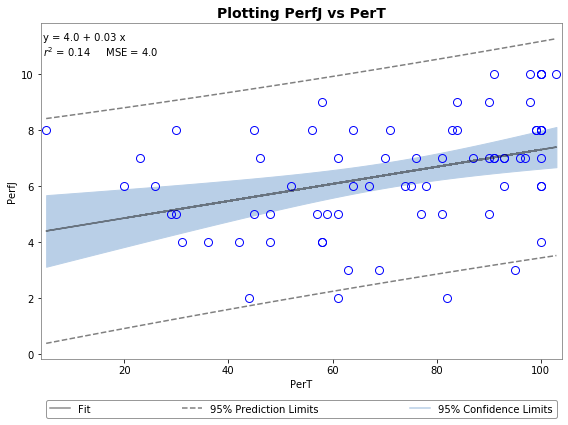

Graph 79 : Plotting Gender 0=Female vs PerT


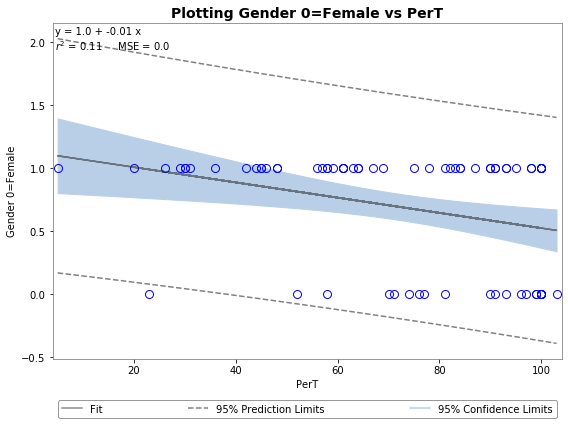

Graph 80 : Plotting Left Force 0=No vs PerT


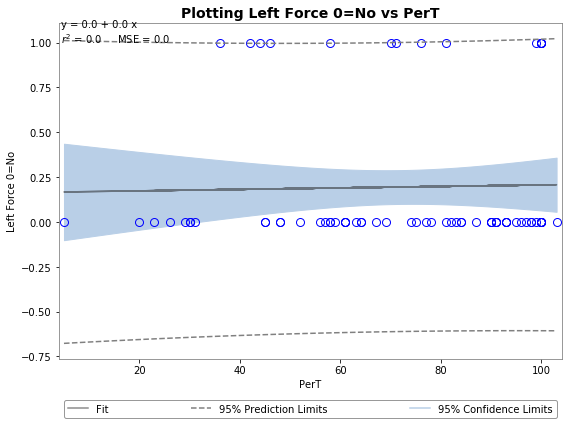

Graph 81 : Plotting GMA vs PerfJ


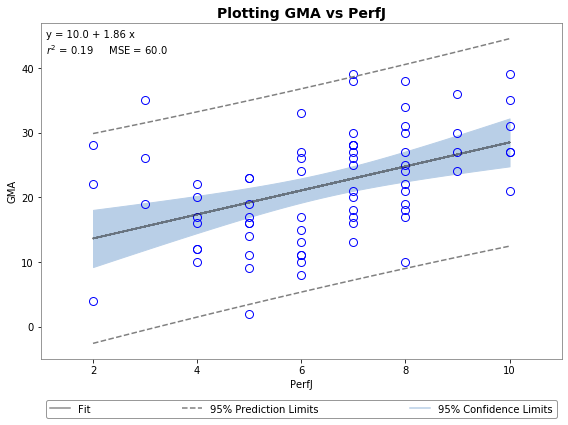

Graph 82 : Plotting EI vs PerfJ


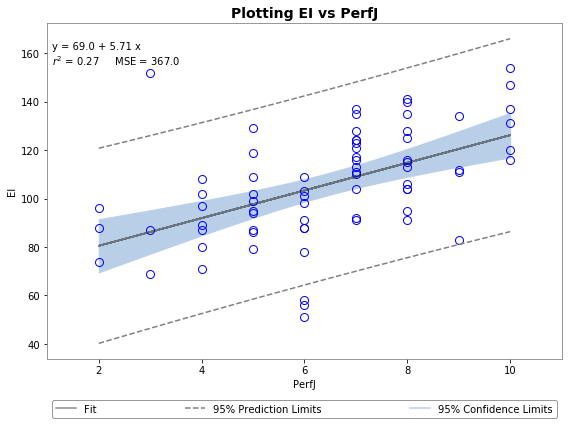

Graph 83 : Plotting Con vs PerfJ


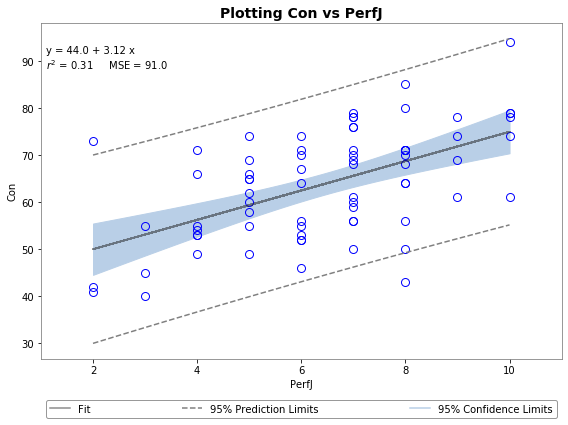

Graph 84 : Plotting EStab vs PerfJ


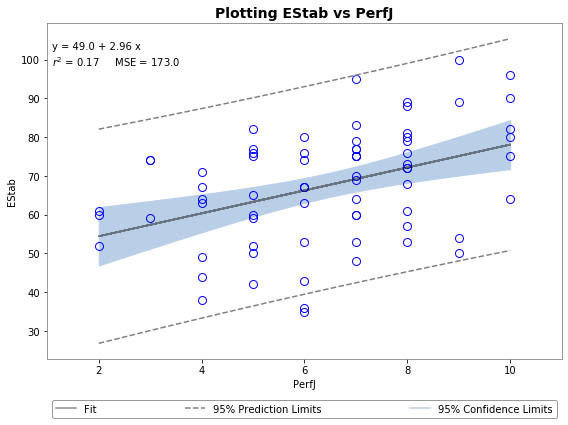

Graph 85 : Plotting Ext vs PerfJ


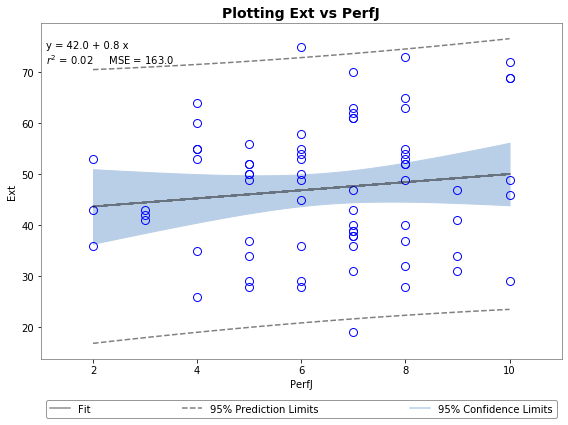

Graph 86 : Plotting Open vs PerfJ


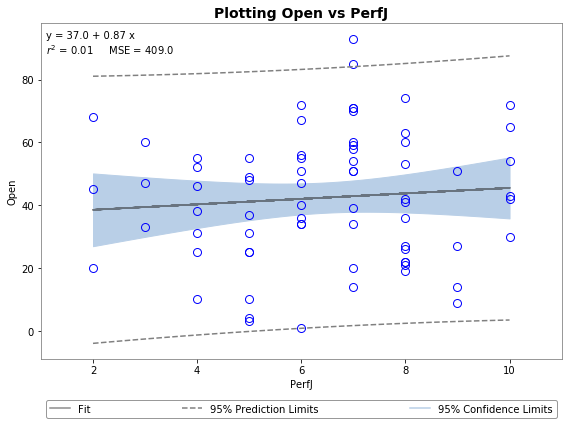

Graph 87 : Plotting Agree vs PerfJ


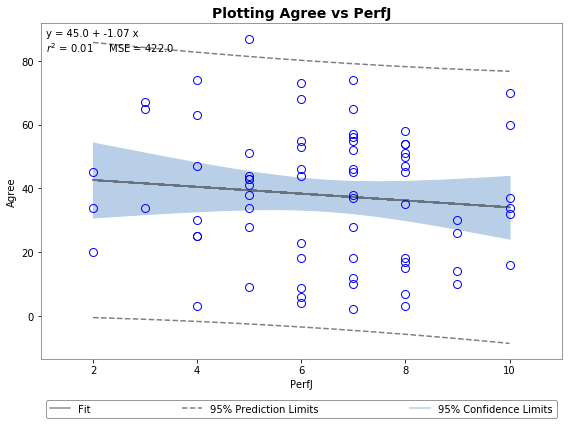

Graph 88 : Plotting PerT vs PerfJ


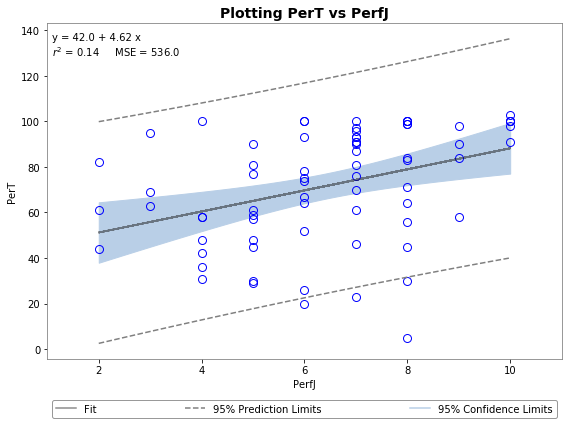

Graph 89 : Plotting Gender 0=Female vs PerfJ


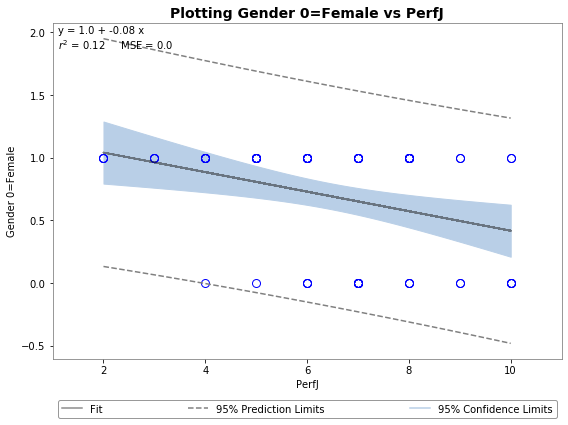

Graph 90 : Plotting Left Force 0=No vs PerfJ


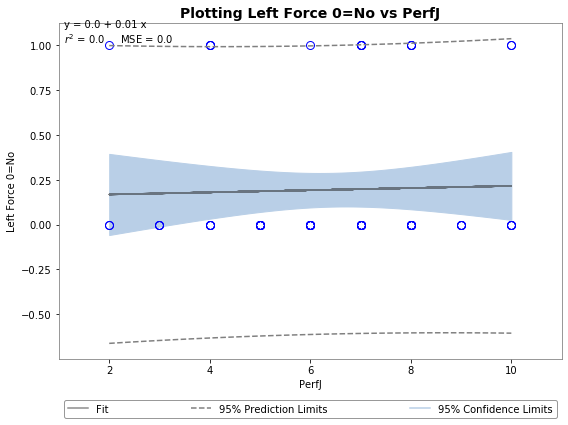

Graph 91 : Plotting GMA vs Gender 0=Female


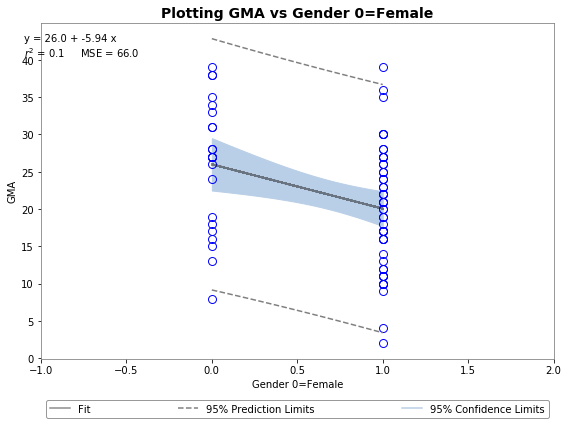

Graph 92 : Plotting EI vs Gender 0=Female


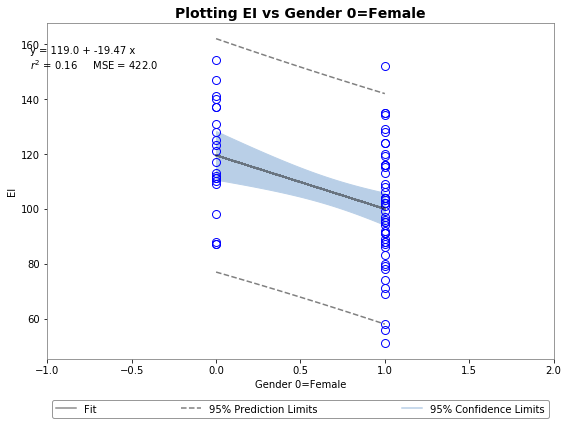

Graph 93 : Plotting Con vs Gender 0=Female


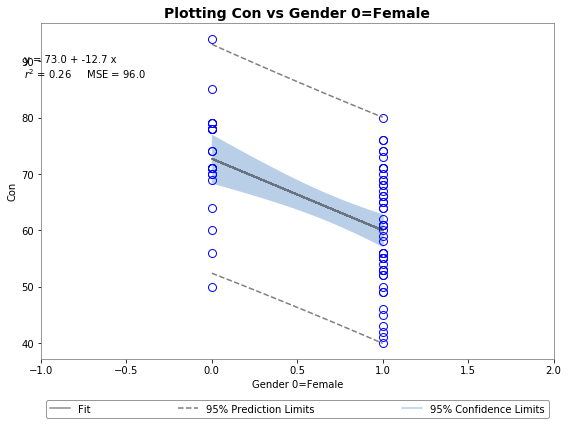

Graph 94 : Plotting EStab vs Gender 0=Female


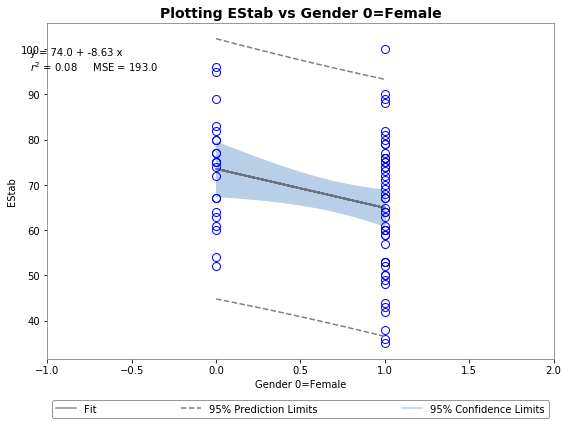

Graph 95 : Plotting Ext vs Gender 0=Female


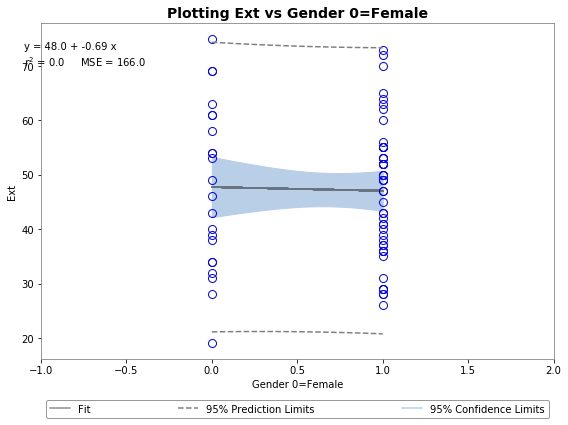

Graph 96 : Plotting Open vs Gender 0=Female


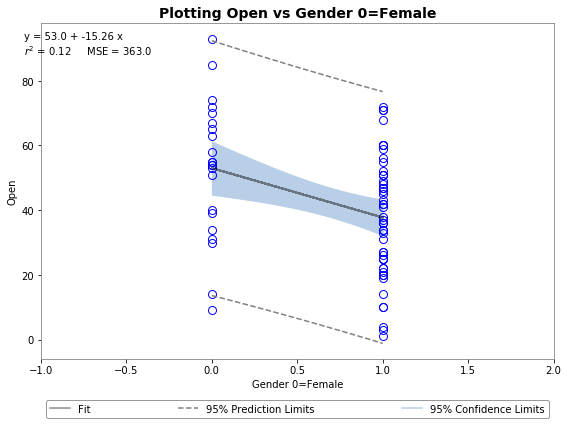

Graph 97 : Plotting Agree vs Gender 0=Female


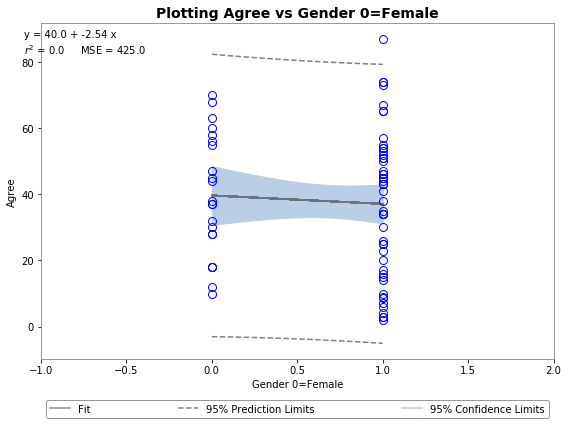

Graph 98 : Plotting PerT vs Gender 0=Female


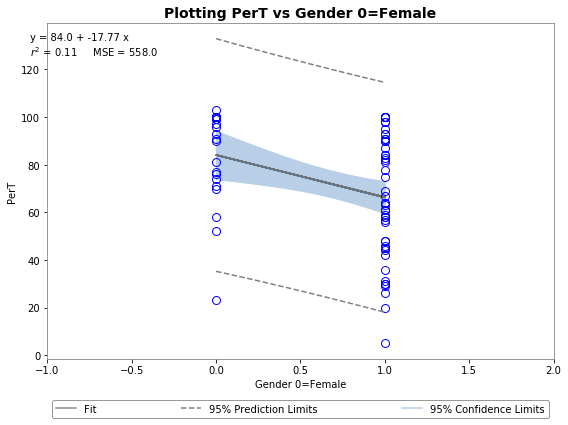

Graph 99 : Plotting PerfJ vs Gender 0=Female


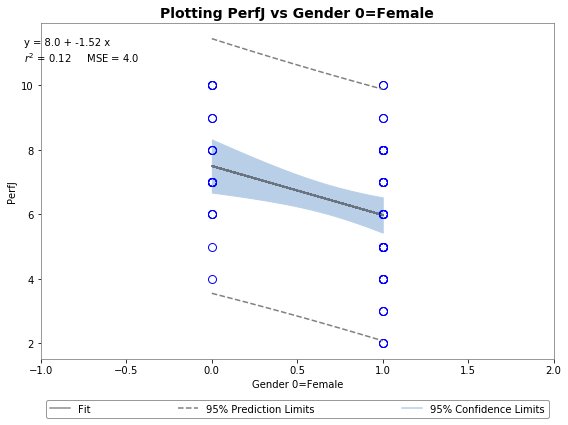

Graph 100 : Plotting Left Force 0=No vs Gender 0=Female


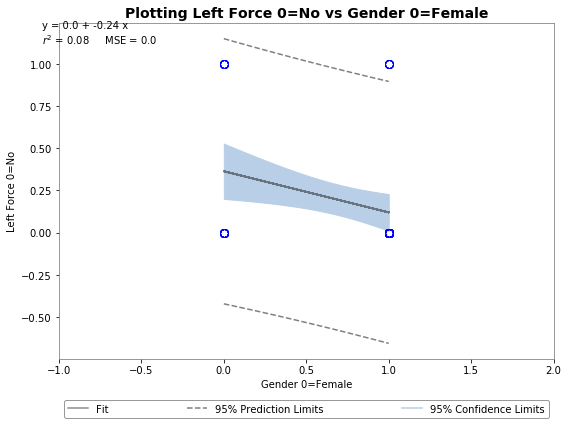

Graph 101 : Plotting GMA vs Left Force 0=No


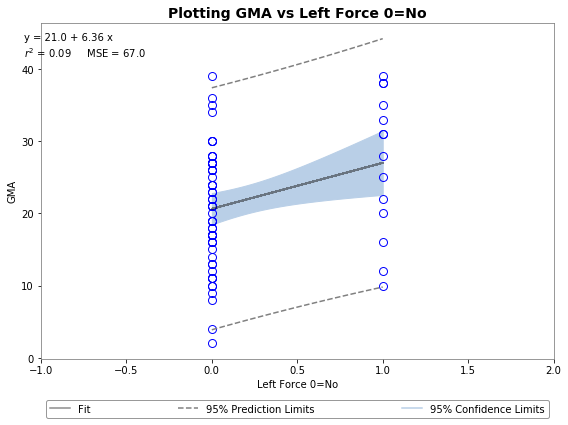

Graph 102 : Plotting EI vs Left Force 0=No


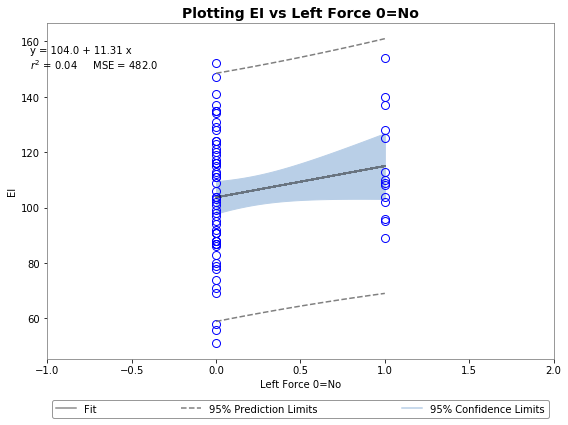

Graph 103 : Plotting Con vs Left Force 0=No


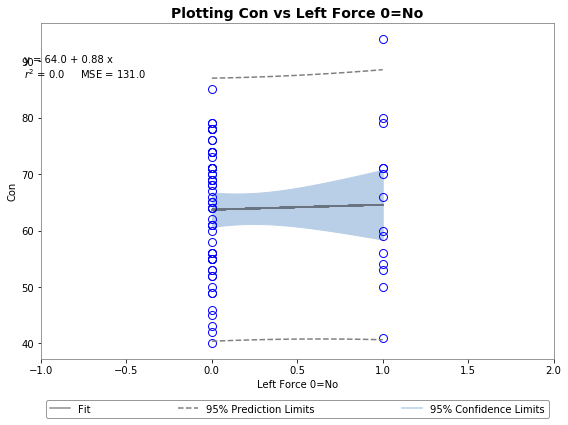

Graph 104 : Plotting EStab vs Left Force 0=No


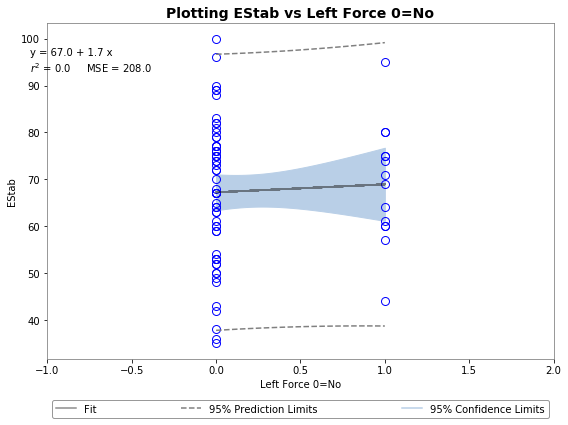

Graph 105 : Plotting Ext vs Left Force 0=No


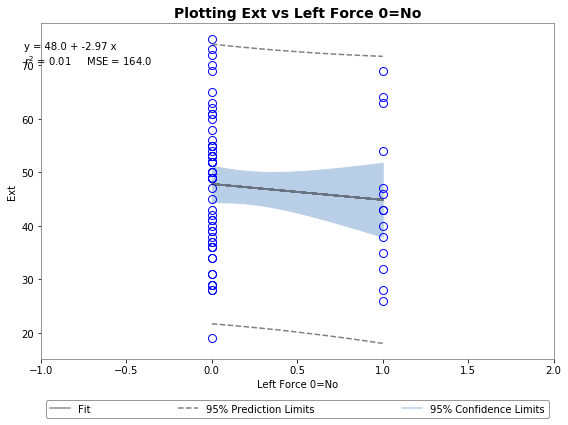

Graph 106 : Plotting Open vs Left Force 0=No


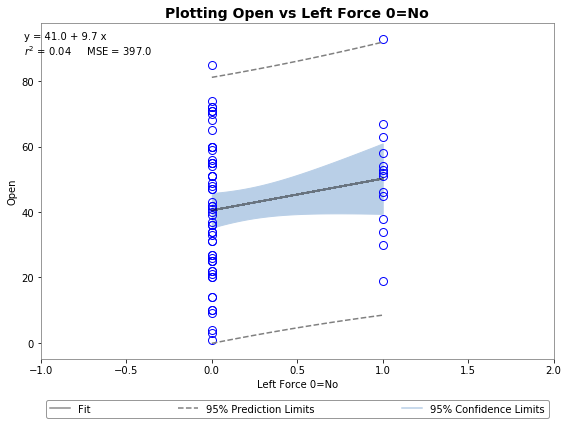

Graph 107 : Plotting Agree vs Left Force 0=No


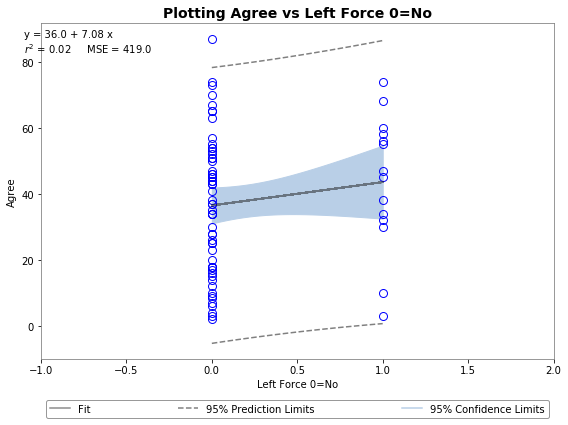

Graph 108 : Plotting PerT vs Left Force 0=No


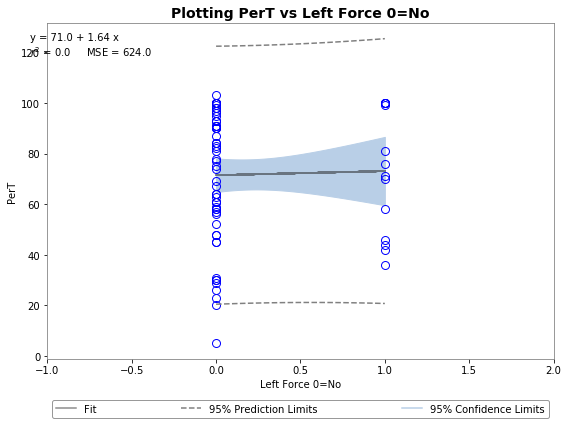

Graph 109 : Plotting PerfJ vs Left Force 0=No


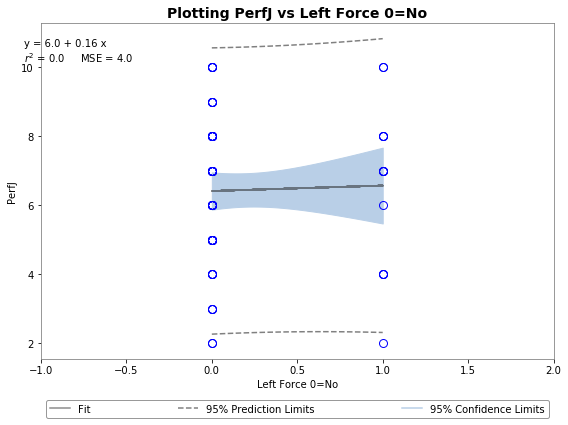

Graph 110 : Plotting Gender 0=Female vs Left Force 0=No


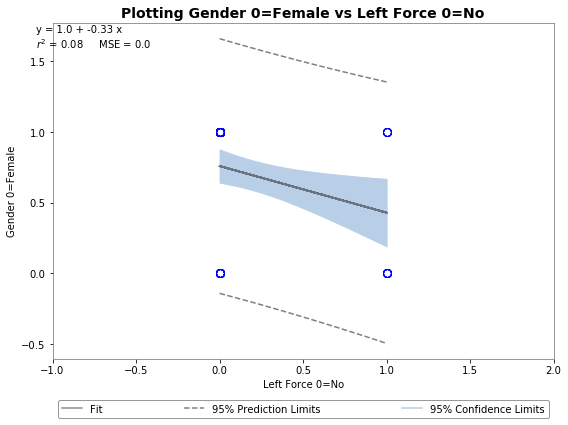

Total  110 combinations


In [24]:
graphs2r2 = defaultdict(lambda : defaultdict(lambda: 1))
def plotpermutations(data):
    columns = data.columns
    tot = 0
    for i, xlabel in enumerate(columns):
        for j in range(len(columns)):
            if i == j : continue
            ylabel = columns[j]
            title = "Plotting " + ylabel + " vs " + xlabel
            print ("Graph", tot+1,":", title)
            r2 = plot(np.ravel(data[xlabel]), np.ravel(data[ylabel]), title, xlabel, ylabel)
            tot += 1
            graphs2r2[xlabel][ylabel] = r2
    print ("Total ", tot, "combinations")
plotpermutations(data)

In [25]:
#Function to plot a selected piece of data
def plotone(data, xlabel, ylabel):
    columns = data.columns
    title = "Plotting " + ylabel + " vs " + xlabel
    plot(np.ravel(data[xlabel]), np.ravel(data[ylabel]), title, xlabel, ylabel)
#plotone(data)

In [27]:
#Get sorted r2 table for each 
from IPython.display import HTML, display
import tabulate
print ("graphs2r2", graphs2r2)
keys = graphs2r2.keys()
table = [[0 for x in range(len(keys)+1)] for _ in range(len(keys)+1)]
for i, key in enumerate(keys):
    table[i+1][0], table[0][i+1] = key, key
    
print ("keys:", keys)
print ("graph2r2[gma]", graphs2r2["GMA"])

for i, key1 in enumerate(keys):
    for j, key2 in enumerate(keys):
        table[i+1][j+1] = round(graphs2r2[key1][key2],2)
        
    
display(HTML(tabulate.tabulate(table, tablefmt='html')))

graphs2r2 defaultdict(<function <lambda> at 0x1a1f73e6a8>, {'GMA': defaultdict(<function <lambda>.<locals>.<lambda> at 0x1a1f73ef28>, {'EI': 0.24475342812590214, 'Con': 0.06283093724151279, 'EStab': 0.019397408235896155, 'Ext': 0.009912110198123863, 'Open': 0.08239054621020679, 'Agree': 0.005709881550082616, 'PerT': 0.36586528136932334, 'PerfJ': 0.19326207755885477, 'Gender 0=Female': 0.10144292065583024, 'Left Force 0=No': 0.0859031212205523, 'GMA': 1}), 'EI': defaultdict(<function <lambda>.<locals>.<lambda> at 0x1a1ffcfea0>, {'GMA': 0.24475342812590214, 'Con': 0.23080380560503708, 'EStab': 0.20191089457827013, 'Ext': 0.052080707046788306, 'Open': 0.15862733150610722, 'Agree': 0.03678641143585821, 'PerT': 0.07495571015692301, 'PerfJ': 0.2687124967134078, 'Gender 0=Female': 0.1602322881410409, 'Left Force 0=No': 0.039918455012970665, 'EI': 1}), 'Con': defaultdict(<function <lambda>.<locals>.<lambda> at 0x1a1fa12ea0>, {'GMA': 0.06283093724151279, 'EI': 0.23080380560503708, 'EStab': 0.01